In [2]:
import sys
if not '../..' in sys.path:
    sys.path.append('../..')
    sys.path.append('..')
from analysis import collection, analysis, emg, plot, model
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import patches, lines
from pathlib import Path
import numpy as np
import seaborn as sns
import scipy as sp
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from joblib import dump, load
from analysis.offsets import offsets

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'axes.labelsize': 16})
mpl.rcParams.update({'figure.figsize': (16*0.8,9*0.8)})
mpl.rcParams.update({'axes.facecolor': "white"})
mpl.rcParams.update({'lines.marker': "+"})
mpl.rcParams.update({'lines.linestyle': ""})
mpl.rcParams.update({"axes.spines.left":   True})
mpl.rcParams.update({"axes.spines.bottom": True})
mpl.rcParams.update({"axes.spines.top":    False})
mpl.rcParams.update({"axes.spines.right":  False})

image_path = Path("/Users/spencer/phd/phd/images/more_results/gmms/")

%matplotlib inline

## look at GMM covariance task/null space projections

In [3]:
subjects = analysis.load_subjects()

In [4]:
import pandas as pd
trajectory_df = pd.read_pickle("../trajectory_dataframe.pkl")
mean_rewards = 1 / trajectory_df.groupby(level=['subject']).mean()["reward"]

In [5]:
subject_idx = 7

In [6]:
# test subspace projection
decoder = subjects[subject_idx].decoder[-2:,:]
task, null = analysis.compute_subspaces(decoder)
print(task.shape, null.shape)

(2, 64) (62, 64)


In [7]:
def stacked_subspace_projection(C,d):
    t, n = analysis.compute_subspaces(d)
    s = np.row_stack([t,n])
    return analysis.subspace_projection(C, s)

In [8]:
models = model.load_trial_models(subject_idx)

In [9]:
# project each component of each model
# model, component, projection vec
projections = np.zeros(shape=(5,12,64))
markers = [".","*","o","v","s"]
for i, m in enumerate(models):
    for k, cov in enumerate(m.covariances_):
        projections[i,k,:] = stacked_subspace_projection(cov,decoder)

## plot the projection of each GMM component covariance for one subject onto task and null

In [13]:
projections.shape

(5, 12, 64)

Text(0.5, 0, 'EMG Channel')

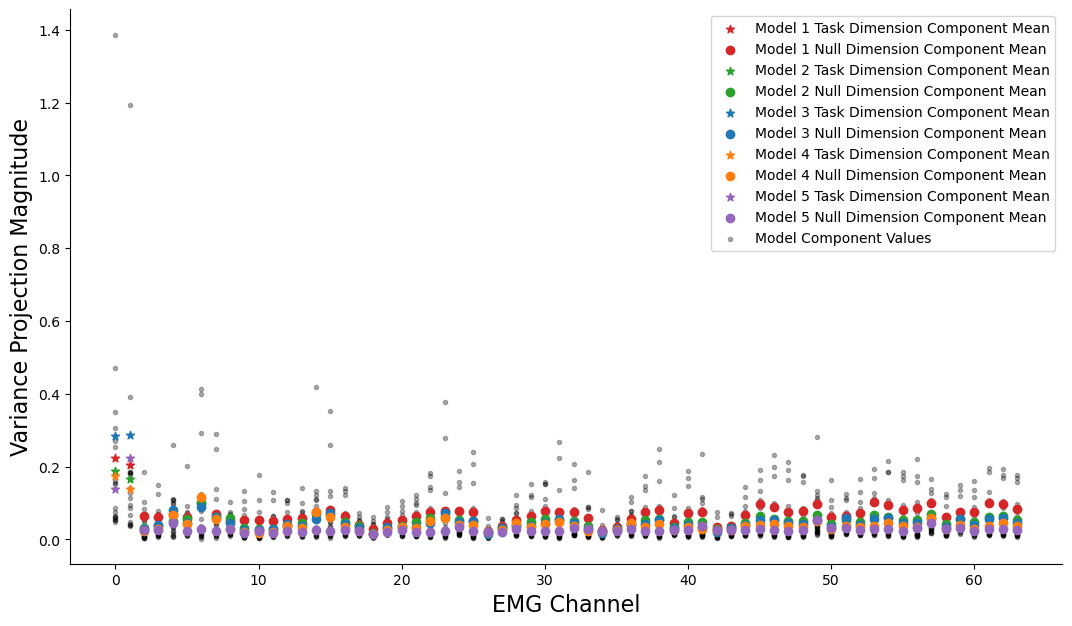

In [26]:
fig = plt.figure()
# plot the projections and color the mean for each model
colors = ["tab:red","tab:green","tab:blue","tab:orange","tab:purple"]
handles = []
for model_idx in range(5):
    for cpt_idx in range(4):
        p = projections[model_idx, cpt_idx]
        h0 = plt.scatter(np.arange(p.shape[0]), p, marker=".",color="k",alpha=0.3)
    for i in range(2):
        h1 = plt.scatter(i, np.mean(projections, axis=1)[model_idx][i], marker="*", c=colors[model_idx],zorder=100)
    for i in range(2,64):
        h2 = plt.scatter(i, np.mean(projections, axis=1)[model_idx][i], marker="o", c=colors[model_idx],zorder=100)
    handles += [h1,h2]
handles += [h0]
labels = []
for i in range(5):
    labels += [f"Model {i+1} Task Dimension Component Mean", f"Model {i+1} Null Dimension Component Mean"]
labels += ["Model Component Values"]
plt.legend(handles=handles,labels=labels)
plt.ylabel("Variance Projection Magnitude")
plt.xlabel("EMG Channel")

In [27]:
plot.save_figure(fig, "variance_projection_example", image_path)

Figure saved to /Users/spencer/phd/phd/images/more_results/gmms/variance_projection_example.pdf


# project models onto task+null space -- movement, calibration, trials

In [28]:
mean_projections = np.zeros(shape=(46,7,12,3))
markers = [".","*","o","v","s"]
for subject_idx in range(46):
    decoder = subjects[subject_idx].decoder[-2:,:]
    models = model.load_log_movement_models(subject_idx) + model.load_log_calibration_models(subject_idx) + model.load_log_trial_models(subject_idx)
    task, null = analysis.compute_subspaces(decoder)
    for i, m in enumerate(models):
        for k, cov in enumerate(m.covariances_):
            mean_projections[subject_idx,i,k,0] = analysis.mean_quadratic_form(cov,task)[0] # *models[i].weights_[k]
            mean_projections[subject_idx,i,k,1] = analysis.mean_quadratic_form(cov,null)[0] # *models[i].weights_[k]            
            mean_projections[subject_idx,i,k,2] = mean_projections[subject_idx,i,k,0] / mean_projections[subject_idx,i,k,1]

## task/null ratio of models

Figure saved to /Users/spencer/phd/phd/images/more_results/gmms/nullspace_ratios_models.pdf
Figure saved to /Users/spencer/phd/phd/images/more_results/gmms/nullspace_pvalues_models.png


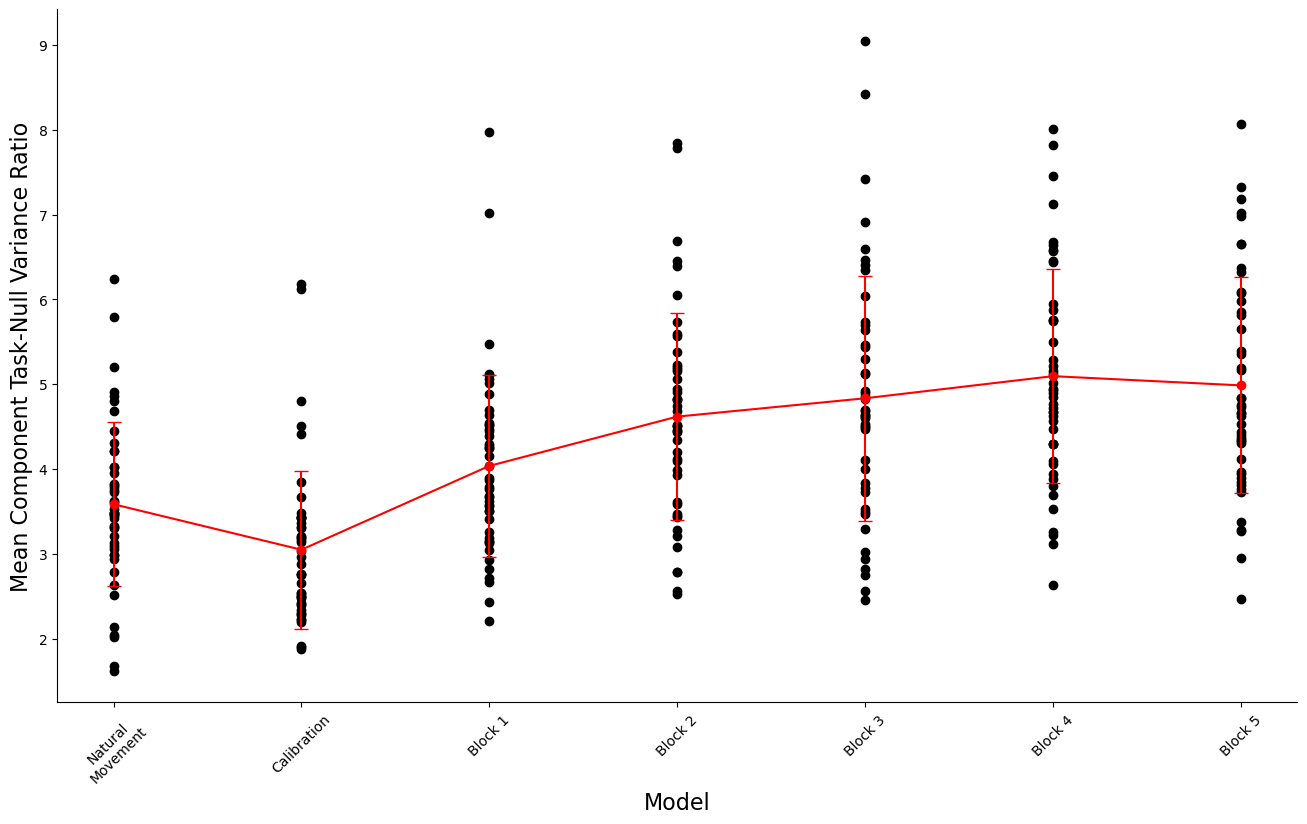

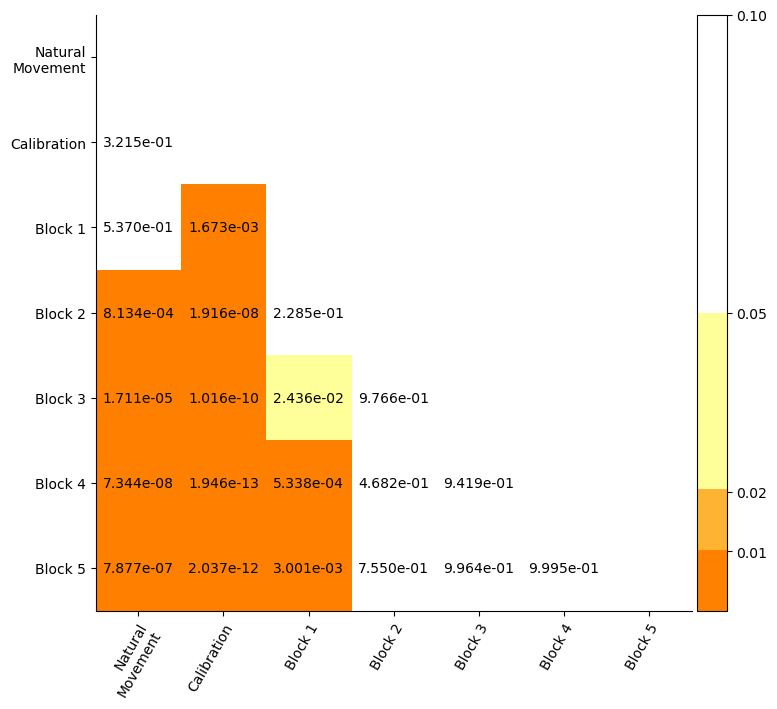

In [29]:
nullspace_ratio_fig = plt.figure(figsize=(16,9))
n_models = mean_projections.shape[1]
xlabels = ["Natural\nMovement", "Calibration", *[f"Block {i+1}" for i in range(n_models-2)]]

for s in range(46):
    for i in range(n_models):
        plt.plot(i, np.mean(mean_projections[s,i,:,2]),'ko')

subject_means = np.mean(mean_projections[:,:,:,2],axis=(2))

plt.errorbar(x=list(range(n_models)),y=np.mean(subject_means,axis=0),yerr=np.std(subject_means,axis=0),marker="o",color='r',capsize=5,linestyle="-")
plt.xticks(range(n_models),xlabels,rotation=45)
plt.xlabel("Model")
plt.ylabel("Mean Component Task-Null Variance Ratio")

from scipy.stats import tukey_hsd
result = tukey_hsd(*(np.array(subject_means.T)))
nullspace_pvalue_fig, _ = plot.annotated_heatmap(result.pvalue,xlabels,xlabels)

plot.save_figure(nullspace_ratio_fig, "nullspace_ratios_models", image_path)
plot.save_figure(nullspace_pvalue_fig, "nullspace_pvalues_models", image_path, format="png")

- plot the data itself
- plot significance matrix

In [31]:
mean_projections.shape

(46, 7, 12, 3)

Text(0, 0.5, 'Null Magnitude')

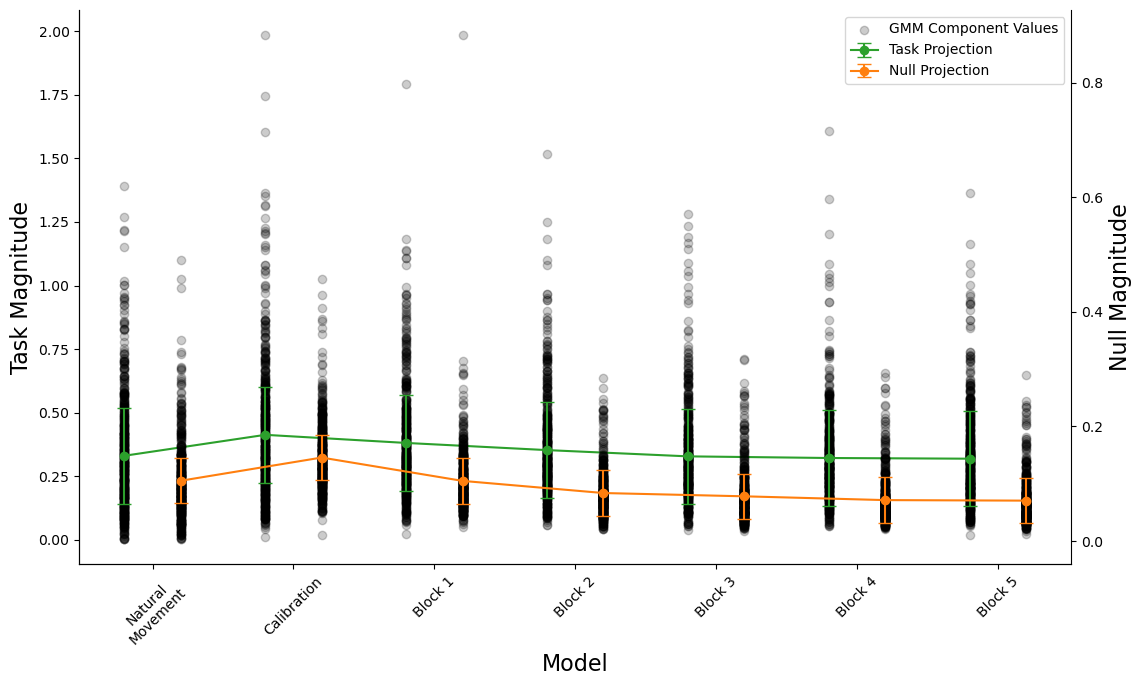

In [52]:
fig = plt.figure()
fig.tight_layout()

handles = []
for i in range(n_models):
    h1 = plt.scatter(x=[i-0.2]*46*12, y=mean_projections[:,i,:,0].reshape(-1), color='k',marker='o',alpha=0.2,label="GMM Component Values")
h2 = plt.errorbar([i-0.2 for i in range(7)], np.mean(mean_projections[:,:,:,0],axis=(0,2)), yerr=np.std(mean_projections[:,i,:,0]), color='tab:green',marker='o',label="Task Projection",capsize=5,linestyle="-")
handles += [h1,h2]
plt.ylabel("Task Magnitude")
plt.xlabel("Model")
plt.xticks(range(n_models),xlabels,rotation=45)

plt.twinx()
for i in range(n_models):
    plt.scatter(x=[i+0.2]*46*12, y=mean_projections[:,i,:,1].reshape(-1), color='k',marker='o',alpha=0.2)
h = plt.errorbar([i+0.2 for i in range(7)], np.mean(mean_projections[:,:,:,1],axis=(0,2)), yerr=np.std(mean_projections[:,i,:,1]), color='tab:orange',marker='o',label="Null Projection",capsize=5,linestyle="-")
handles += [h]

plt.gca().spines[["right"]].set_visible(True)
plt.legend(handles=handles)
plt.ylabel("Null Magnitude")


In [49]:
plot.save_figure(fig, "null_task_magnitude_gmm", image_path)

Figure saved to /Users/spencer/phd/phd/images/more_results/gmms/null_task_magnitude_gmm.pdf


In [53]:
mean_projections.shape

(46, 7, 12, 3)

Figure saved to /Users/spencer/phd/phd/images/more_results/gmms/nullspace_pvalues_models_task_significance.png
Figure saved to /Users/spencer/phd/phd/images/more_results/gmms/nullspace_pvalues_models_null_significance.png


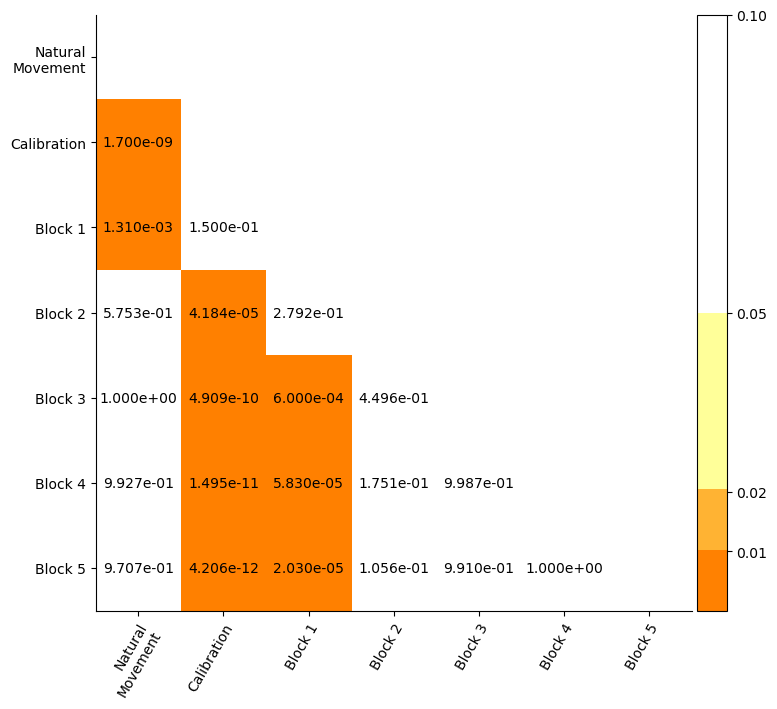

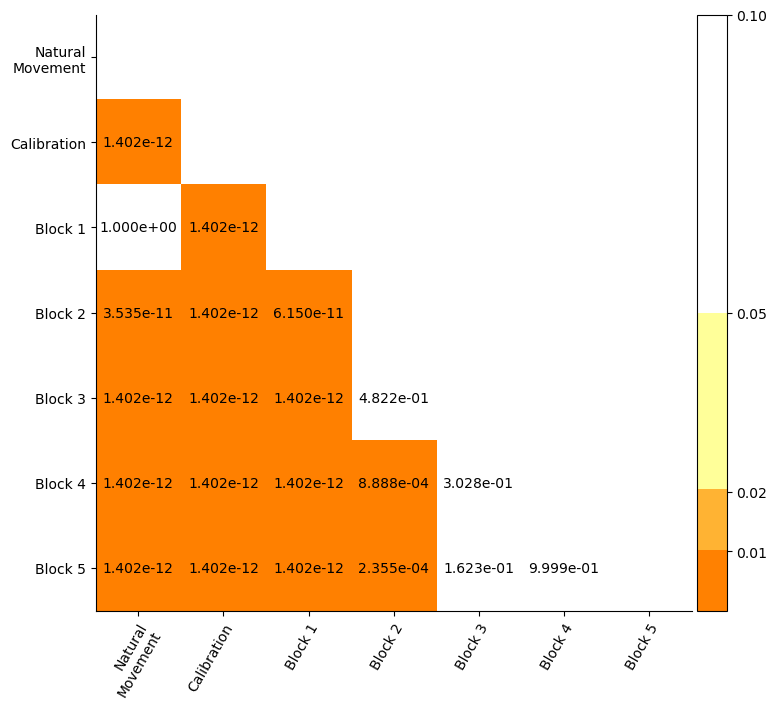

In [56]:
result_task = tukey_hsd(*(np.array(mean_projections[:,:,:,0].transpose(1,0,2).reshape(7,-1))))
result_null = tukey_hsd(*(np.array(mean_projections[:,:,:,1].transpose(1,0,2).reshape(7,-1))))

nullspace_pvalue_fig_task, (ax_task, cax_task) = plot.annotated_heatmap(result_task.pvalue,xlabels,xlabels)
nullspace_pvalue_fig_null, (ax_null, cax_null) = plot.annotated_heatmap(result_null.pvalue,xlabels,xlabels)

plot.save_figure(nullspace_pvalue_fig_task, "nullspace_pvalues_models_task_significance", image_path, format="png")
plot.save_figure(nullspace_pvalue_fig_null, "nullspace_pvalues_models_null_significance", image_path, format="png")